In [1]:
import math
import cmath
from random import uniform
from scipy.integrate import quad
import numpy as np
from numpy import linalg
from scipy import signal
import time
import matplotlib.pyplot as plt

In [2]:
from qiskit import QuantumCircuit, transpile
#from qiskit_aer import AerSimulator
from qiskit.quantum_info import SparsePauliOp, Statevector
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

## Implement $T_{N,K}f$

In [3]:
class Polynomial:
    def __init__(self, coefficients):
        self.coefficients = list(coefficients)
        self.degree = len(coefficients) - 1

    def get_degree(self):
        return self.degree

    def get_coefficient(self):
        return self.coefficients

    def evaluate(self, x):
        result = 0
        for i in range(self.degree + 1):
            result += self.coefficients[i] * math.pow(x, i)
        return result

    def find_roots(self):
        return np.roots(self.coefficients[::-1])

    def __repr__(self):
        terms = []
        for i, coef in enumerate(self.coefficients):
            if coef != 0:
                if i == 0:
                    terms.append(f"{coef}")
                elif i == 1:
                    terms.append(f"{coef}x")
                else:
                    terms.append(f"{coef}x^{i}")
        return " + ".join(terms) if terms else "0"

    def __mul__(self, other):
        deg_P = self.degree
        deg_Q = other.degree
        coefs_P = self.coefficients
        coefs_Q = other.coefficients

        result_coefs = [0] * (deg_P + deg_Q + 1)
        for i in range(deg_P + 1):
            for j in range(deg_Q + 1):
                result_coefs[i + j] += coefs_P[i] * coefs_Q[j]

        return Polynomial(result_coefs)

In [4]:
class TriPoly:
    def __init__(self, degree, coefficients):
        self.coefficients = coefficients
        self.degree = degree

    def get_degree(self):
        return self.degree

    def get_coefficient(self):
        return self.coefficients

    def evaluate(self, x):
        result = self.coefficients[0]
        for i in range(1, self.degree + 1):
            result += self.coefficients[i] * np.exp(complex(0, 1) * i * x)
            result += self.coefficients[-i] * np.exp(-(complex(0, 1) * i * x))
        return result

In [5]:
def main_function_Jkernel(N, r, t):
    if (t == 0):
        return pow(math.floor(N/2) + 1, 2 * r)
    return pow(np.sin((t/2) * (1 + math.floor(N/2))) / np.sin(t/2) , 2 * r)

def find_lambda(N, r): # we can pre-compute this
    func = lambda t: main_function_Jkernel(N, r, t)
    return quad(func, -math.pi, math.pi, limit=200)[0]

def Jkernel(N, r, t):
    return main_function_Jkernel(N, r, t) / find_lambda(N, r)

In [6]:
def mathcalT(f, N, K, x):
    r = math.ceil((K + 3)/2)
    func = lambda t: Jkernel(N, r, t) * sum(math.pow(-1, k+1) * math.comb(K+1, k) * f(x + k*t) for k in range(1, K+2))
    return quad(func, -math.pi, math.pi, limit=200)[0]

In [7]:
def Fourier_coef(f, n):
    func_real = lambda x: np.real(f(x) * np.exp(-complex(0,1) * n * x))
    func_imag = lambda x: np.imag(f(x) * np.exp(-complex(0,1) * n * x))
    return (quad(func_real, -math.pi, math.pi)[0] + complex(0,1) * quad(func_imag, -math.pi, math.pi)[0])  / (2 * math.pi)

In [8]:
def count_vectors(r, a, b, n): # count vectors z in \mathbb{Z}^r such that a <= z_i <= b and norm_1(z) = n
    if int(2*a) % 2:
        a = int(a + 0.5)
        b = int(b + 0.5)
        n = n + int(r / 2)
    else:
        a = int(a)
        b = int(b)
    if r <= 0:
        return 1 if n == 0 else 0
    m = b - a
    S = n - r * a
    if S < 0 or S > r * m:
        return 0
    total = 0
    max_j = S // (m + 1)
    for j in range(0, max_j + 1):
        sign = -1 if (j % 2 == 1) else 1
        top = S - j * (m + 1) + r - 1
        if top < r - 1:
            continue
        term = math.comb(r, j) * math.comb(top, r - 1)
        total += sign * term
    return total

def m_l(r, l, N):
    return count_vectors(2*r, -math.floor(N/2)/2, math.floor(N/2)/2, l)

In [9]:
def m_nK(n, N, K):
    result = 0
    r = math.ceil((K + 3)/2)
    k = 1
    while (k <= K+1 and k*abs(n) <= r*math.floor(N/2)):
        result += pow(-1, k+1) * math.comb(K+1, k) * m_l(r, k*n, N)
        k += 1
    return result

In [10]:
def trig_mathcalT(f, N, K):
    r = math.ceil((K + 3)/2)
    coefs = [0] * (2*r*math.floor(N/2) + 1)
    n = -r*math.floor(N/2)
    while(n <= r*math.floor(N/2)):
        coefs[n] = m_nK(n, N, K) * Fourier_coef(f, n) * 2 * math.pi / find_lambda(N, r)
        n += 1

    return TriPoly(r*math.floor(N/2), coefs)

## Find parameters

In [11]:
class LaurentPoly:
    def __init__(self, degree, coefficients):
        self.coefficients = coefficients
        self.degree = degree

    def get_degree(self):
        return self.degree

    def get_coefficient(self):
        return self.coefficients

    def evaluate(self, x):
        result = self.coefficients[0]
        for i in range(1, self.degree + 1):
            result += self.coefficients[i] * np.exp(complex(0, 1) * i * x / 2)
            result += self.coefficients[-i] * np.exp(-(complex(0, 1) * i * x) / 2)
        return result

    def conjugate(self):
        coefs = [element.conjugate() for element in self.coefficients]
        for n in range(1, self.get_degree() + 1):
            tem = coefs[n]
            coefs[n] = coefs[-n]
            coefs[-n] = tem
        return LaurentPoly(self.degree, coefs)

    def rescale(self, c):
        coefs = [element / c for element in self.coefficients]
        return LaurentPoly(self.degree, coefs)

    def lower_deg_by_2(self):
        deg = self.degree
        new_deg = deg - 2
        new_coefs = [0] * (new_deg * 2 + 1)
        for i in range(-new_deg, new_deg + 1):
            new_coefs[i] = self.coefficients[i]
        return LaurentPoly(new_deg, new_coefs)

    def minus_by_one(self):
        coefs = [0] * (self.degree * 2 + 1)
        for i in range(- self.degree, self.degree + 1):
            coefs[i] = - self.coefficients[i]
            if i == 0:
                coefs[i] += 1
        return LaurentPoly(self.degree, coefs)

    def __add__(self, other):
        P = self
        Q = other
        if Q.get_degree() < P.get_degree():
            P, Q = Q, P
        coefs = Q.get_coefficient()
        for i in range(- P.get_degree(), P.get_degree() + 1):
            coefs[i] += P.get_coefficient()[i]
        return LaurentPoly(Q.get_degree(), coefs)

    def __mul__(self, other):
        P = self
        Q = other
        coefs = [0] * ((P.get_degree() + Q.get_degree())*2 + 1)
        for i in range(- P.get_degree(), P.get_degree() + 1):
            for j in range(- Q.get_degree(), Q.get_degree() + 1):
                coefs[i+j] += P.get_coefficient()[i] * Q.get_coefficient()[j]
        return LaurentPoly(P.get_degree() + Q.get_degree(), coefs)

In [12]:
def convert_TriPoly_to_LaurentPoly(P):
    deg = 2*P.get_degree()
    coefs = [0] * (2*deg + 1)
    for n in range(-P.get_degree(), P.get_degree()+1):
        coefs[2*n] = P.get_coefficient()[n]
    return LaurentPoly(deg, coefs)

In [13]:
def add(P, Q):
    if Q.get_degree() < P.get_degree():
        P, Q = Q, P
    coefs = Q.get_coefficient()
    for i in range(- P.get_degree(), P.get_degree() + 1):
        coefs[i] += P.get_coefficient()[i]
    return LaurentPoly(Q.get_degree(), coefs)

def multiply(P, Q):
    coefs = [0] * ((P.get_degree() + Q.get_degree())*2 + 1)
    for i in range(- P.get_degree(), P.get_degree() + 1):
        for j in range(- Q.get_degree(), Q.get_degree() + 1):
            coefs[i+j] += P.get_coefficient()[i] * Q.get_coefficient()[j]
    return LaurentPoly(P.get_degree() + Q.get_degree(), coefs)

def oneminus(P):
    coefs = [0] * (P.get_degree() * 2 + 1)
    for i in range(- P.get_degree(), P.get_degree() + 1):
        coefs[i] = - P.get_coefficient()[i]
        if i == 0:
            coefs[i] += 1
    return LaurentPoly(P.get_degree(), coefs)

def lower_deg_by_2(P):
    deg = P.get_degree()
    new_deg = deg - 2
    new_coefs = [0] * (new_deg * 2 + 1)
    for i in range(-new_deg, new_deg + 1):
        new_coefs[i] = P.get_coefficient()[i]
    return LaurentPoly(new_deg, new_coefs)

In [14]:
def pair_conjugates(roots):
    result = []
    matched = [0] * len(roots)
    for i in range(len(roots)):
        if matched[i]:
            continue
        matched[i] = 1
        simi_score = 100
        for j in range(len(roots)):
            if matched[j]:
                continue
            if abs(1/roots[i].conjugate() - roots[j]) < simi_score:
                cur_ind = j
                simi_score = abs(1/roots[i].conjugate() - roots[j])
        result.append([roots[i], roots[cur_ind]])
        matched[cur_ind] = 1
    return result

In [15]:
def find_Q(P):
    A = oneminus(multiply(P, P.conjugate()))
    deg = A.get_degree()
    coefs = [0] * (2*deg + 1)
    #print(A.get_coefficient()[deg])
    for n in range(2*deg + 1):
        coefs[n] = A.get_coefficient()[-deg + n] / A.get_coefficient()[deg]
    B = Polynomial(coefs)
    roots = B.find_roots()
    conj_pairs = pair_conjugates(roots)
    const = A.get_coefficient()[deg]
    C = Polynomial([1])
    for i in range(deg):
        const *= conj_pairs[i][0]
        C = C * Polynomial([-conj_pairs[i][1], 1])
    const = math.sqrt(const.real)
    coefs_Q = [0] * (deg + 1)
    for n in range(-int(deg/2), int(deg/2) + 1):
        coefs_Q[n] = C.get_coefficient()[n+int(deg/2)] * const
    Q = LaurentPoly(int(deg/2), coefs_Q)
    if np.round(add(multiply(Q, Q.conjugate()), multiply(P, P.conjugate())).get_coefficient()[0]) != 1:
        print("Warning: Incompatible value of N. Try restricting N <= 27")
    return Q


In [16]:
def find_parameters(P, Q):
    M = P.get_degree()
    theta = [0] * (M+1)
    phi = [0] * (M+2)
    newP, newQ = P, Q
    for i in range(M, 0, -1):
        z = (-newP.get_coefficient()[i]) / newQ.get_coefficient()[i]
        theta[i] = 2*math.atan(abs(z))
        phi[i] = -cmath.phase(z / math.tan(theta[i]/2))
        newP, newQ = lower_deg_by_2(add(multiply(newP, LaurentPoly(1, [0, np.exp(complex(0,1)*phi[i]/2) * np.cos(theta[i]/2), 0])), multiply(newQ , LaurentPoly(1, [0, np.exp( - complex(0,1)*phi[i]/2) * np.sin(theta[i]/2), 0])))), lower_deg_by_2(add(multiply(newP, LaurentPoly(1, [0, 0, -np.exp(complex(0,1)*phi[i]/2) * np.sin(theta[i]/2)])), multiply(newQ , LaurentPoly(1, [0, 0, np.exp(-complex(0,1)*phi[i]/2) * np.cos(theta[i]/2)]))))

    theta[0] = 2 * math.acos(abs(newP.get_coefficient()[0]))
    phi[0] = cmath.phase(newQ.get_coefficient()[0]) - cmath.phase(newP.get_coefficient()[0])
    phi[-1] = - cmath.phase(newQ.get_coefficient()[0]) - cmath.phase(newP.get_coefficient()[0])
    return theta, phi

In [17]:
def build_circuit(para, x):
    qc = QuantumCircuit(1)

    qc.rz(para[1][-1], 0)
    qc.ry(para[0][0], 0)
    qc.rz(para[1][0], 0)

    for i in range(1, len(para[0])):
        qc.rz(x, 0)
        qc.ry(para[0][i], 0)
        qc.rz(para[1][i], 0)

    return qc

## Plots

In [18]:
def qc_output(f, x, N, K):
    trigTf = trig_mathcalT(f, N, K)
    P = convert_TriPoly_to_LaurentPoly(trigTf)
    Q = find_Q(P)
    para = find_parameters(P,Q)
    qc = build_circuit(para, x)
    return Statevector.from_instruction(qc).data[0]

In [64]:
N, K = 10, 0
x = 3.14
f1 = lambda x : abs(np.sin(x))
print(f1(x), qc_output(f1, x, N, K))
print(f1(x) - qc_output(f1, x, N, K).real)

0.0015926529164868282 (0.2165514328682279+1.642310910881942e-15j)
-0.21495877995174106


In [21]:
N, K = 10, 1
x = 0.56
f2 = lambda x : abs(np.sin(x))**2.5
print(f2(x), qc_output(f2, x, N, K))


0.20564443196546178 (0.1587254259252765-0.0019160655080647398j)


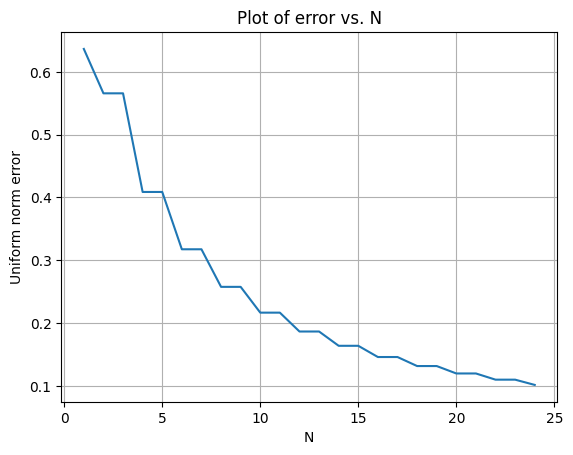

In [63]:
x, y = [], []
f = lambda x : abs(np.sin(x))
for N in range(1, 25):
    err = []
    x.append(N)
    x_0 = 0.0
    while x_0 < 2*math.pi:
        err.append(abs(f(x_0) - qc_output(f, x_0, N, 0).real))
        x_0 += 0.02
    y.append(max(err))

# f = lambda x: abs(np.sin(x))
# x = np.arange(0, 2*np.pi, 0.05)
# y = f(x)

plt.plot(x, y, label='f(x)')
plt.xlabel('N')
plt.ylabel('Uniform norm error')
plt.title('Plot of error vs. N')
#plt.legend()
plt.grid(True)
plt.show()

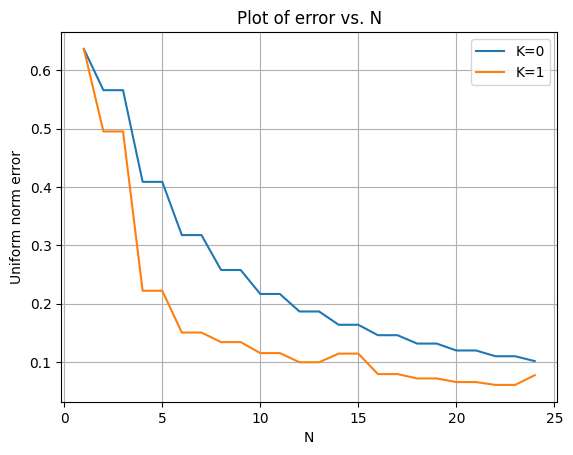

In [66]:
x, out = [i for i in range(1,25)], []
f = lambda x : abs(np.sin(x))

for K in range(2):
    tem = []
    for N in range(1, 25):
        err = []
        x_0 = 0.0
        while x_0 < 2*math.pi:
            err.append(abs(f(x_0) - qc_output(f, x_0, N, K).real))
            x_0 += 0.05
        tem.append(max(err))
    out.append(tem)

# f = lambda x: abs(np.sin(x))
# x = np.arange(0, 2*np.pi, 0.05)
# y = f(x)

plt.plot(x, out[0], label='K=0')
plt.plot(x, out[1], label='K=1')
#plt.plot(x, out[2], label='K=2')

plt.xlabel('N')
plt.ylabel('Uniform norm error')
plt.title('Plot of error vs. N')
plt.legend()
plt.grid(True)
plt.show()

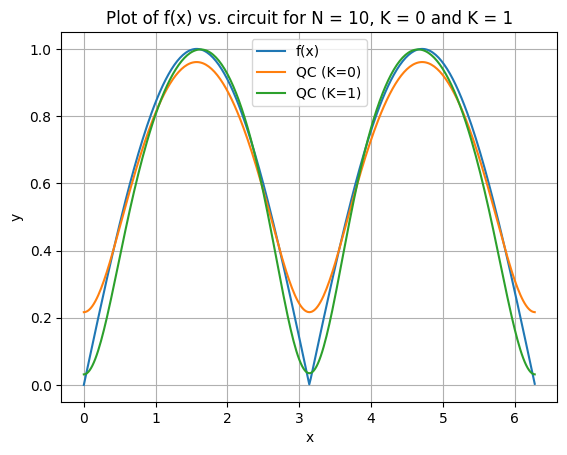

In [57]:
N = 10

f = lambda x : abs(np.sin(x))
circuit_0 = lambda x: qc_output(f, x, N, 0).real
circuit_1 = lambda x: qc_output(f, x, N, 1).real

X = np.arange(0, 2*np.pi, 0.02)
y_0 = [f(x) for x in X]
y_1 = [circuit_0(x) for x in X]
y_2 = [circuit_1(x) for x in X]

plt.plot(X, y_0, label='f(x)')
plt.plot(X, y_1, label='QC (K=0)')
plt.plot(X, y_2, label='QC (K=1)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of f(x) vs. circuit for N = 10, K = 0 and K = 1')
plt.legend()
plt.grid(True)
plt.show()

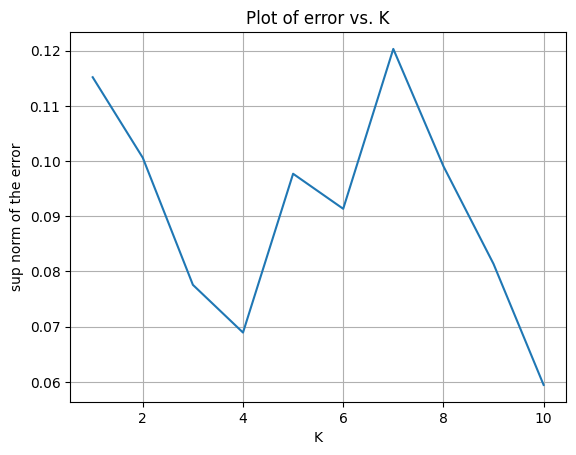

In [71]:
x, y = [], []
f = lambda x : abs(np.sin(x))
for K in range(1, 11):
    err = []
    x.append(K)
    x_0 = 0.0
    while x_0 < 2*math.pi:
        err.append(abs(f(x_0) - qc_output(f, x_0, 10, K).real))
        x_0 += 0.05
    y.append(max(err))

# f = lambda x: abs(np.sin(x))
# x = np.arange(0, 2*np.pi, 0.05)
# y = f(x)

plt.plot(x, y, label='f(x)')
plt.xlabel('K')
plt.ylabel('sup norm of the error')
plt.title('Plot of error vs. K')
#plt.legend()
plt.grid(True)
plt.show()

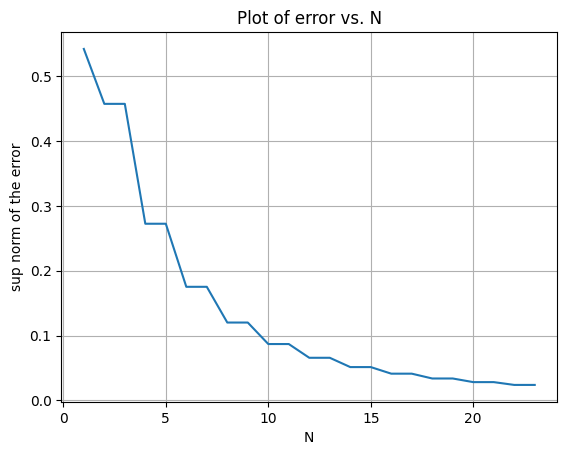

In [67]:
x, y = [], []
f = lambda x : abs(np.sin(x))**2.5
for N in range(1, 24):
    err = []
    x.append(N)
    x_0 = 0.0
    while x_0 < 2*math.pi:
        err.append(abs(f(x_0) - qc_output(f, x_0, N, 0).real))
        x_0 += 0.05
    y.append(max(err))

# f = lambda x: abs(np.sin(x))
# x = np.arange(0, 2*np.pi, 0.05)
# y = f(x)

plt.plot(x, y, label='f(x)')
plt.xlabel('N')
plt.ylabel('sup norm of the error')
plt.title('Plot of error vs. N')
#plt.legend()
plt.grid(True)
plt.show()

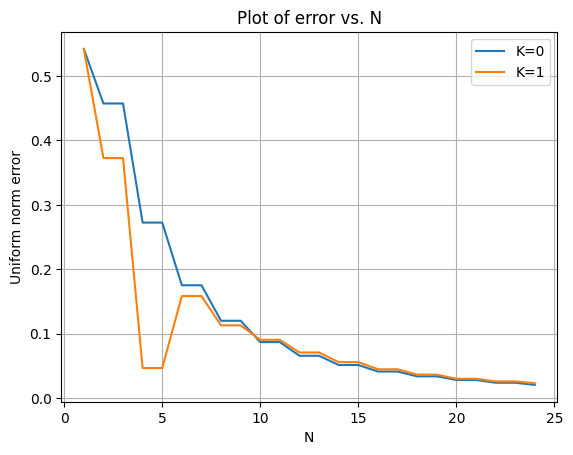

In [68]:
x, out = [i for i in range(1,25)], []
f = lambda x : abs(np.sin(x))**2.5

for K in range(2):
    tem = []
    for N in range(1, 25):
        err = []
        x_0 = 0.0
        while x_0 < 2*math.pi:
            err.append(abs(f(x_0) - qc_output(f, x_0, N, K).real))
            x_0 += 0.05
        tem.append(max(err))
    out.append(tem)

# f = lambda x: abs(np.sin(x))
# x = np.arange(0, 2*np.pi, 0.05)
# y = f(x)

plt.plot(x, out[0], label='K=0')
plt.plot(x, out[1], label='K=1')
#plt.plot(x, out[2], label='K=2')

plt.xlabel('N')
plt.ylabel('Uniform norm error')
plt.title('Plot of error vs. N')
plt.legend()
plt.grid(True)
plt.show()

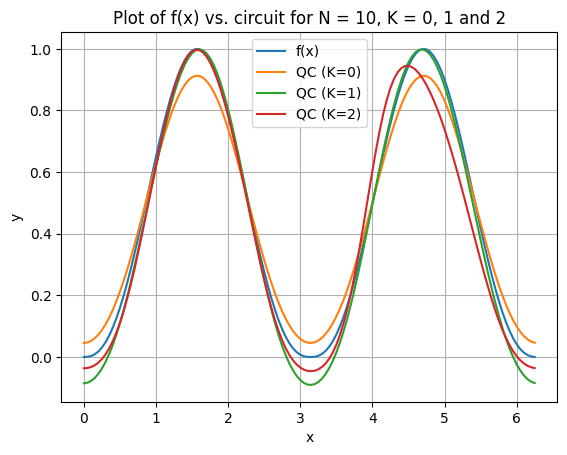

In [ ]:
N = 10

f = lambda x : abs(np.sin(x))**2.5
circuit_0 = lambda x: qc_output(f, x, N, 0).real
circuit_1 = lambda x: qc_output(f, x, N, 1).real
circuit_2 = lambda x: qc_output(f, x, N, 2).real

X = np.arange(0, 2*np.pi, 0.05)
y_0 = [f(x) for x in X]
y_1 = [circuit_0(x) for x in X]
y_2 = [circuit_1(x) for x in X]
y_3 = [circuit_2(x) for x in X]


plt.plot(X, y_0, label='f(x)')
plt.plot(X, y_1, label='QC (K=0)')
plt.plot(X, y_2, label='QC (K=1)')
plt.plot(X, y_3, label='QC (K=2)')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Plot of f(x) vs. circuit for N = 10, K = 0, 1')
plt.legend()
plt.grid(True)
plt.show()

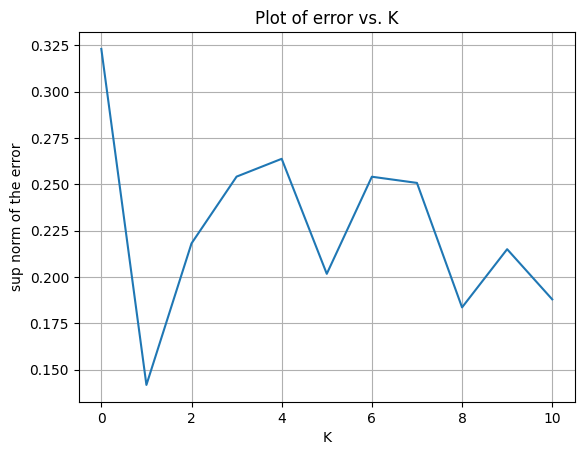

In [72]:
x, y = [], []
f = lambda x : abs(np.cos(x))**15
for K in range(0, 11):
    err = []
    x.append(K)
    x_0 = 0.0
    while x_0 < 2*math.pi:
        err.append(abs(f(x_0) - qc_output(f, x_0, 10, K).real))
        x_0 += 0.025
    y.append(max(err))

# f = lambda x: abs(np.sin(x))
# x = np.arange(0, 2*np.pi, 0.05)
# y = f(x)

plt.plot(x, y, label='f(x)')
plt.xlabel('K')
plt.ylabel('sup norm of the error')
plt.title('Plot of error vs. K')
#plt.legend()
plt.grid(True)
plt.show()